# Cover It !

In [1]:
import numpy as np
# import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = (16,9)

import argparse
import os
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
from torchvision.utils import save_image

from skimage import io
from PIL import Image, ImageOps

**Configs**

In [2]:
PROJECT_DIR = '/home/kazim/Desktop/project/cover_it'
IMAGE_SIZE = (256,256)
BATCH_SIZE = 16

# Data Preperation

In [3]:
os.listdir(f'{PROJECT_DIR}/data/raw/coco-test2017')[0]

'000000097198.jpg'

In [4]:
class CoverItDataset(Dataset):
    """Cover It dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.indexdict = {idx:image for idx,image in enumerate(os.listdir(self.root_dir))}

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir,
                                    str(self.indexdict[idx]))
    
        image = io.imread(img_path)
        
        if image.shape[-1] != 3: #black white photo
#             print(f"image:{img_path} || must have 3 color channels!")
#             print(image.shape)
            h,w = image.shape
            image = (image * np.ones((1,1,1), dtype=np.int8)).transpose(1,2,0)

        sample = image

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
## DEBUG

# img_path = "/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000059177.jpg"
# # img_path = "/home/kazim/Desktop/project/cover_it/data/raw/coco-test2017/000000000001.jpg"

# image = io.imread(img_path)
# image.shape

In [6]:
# h,w = image.shape
# image = (image * np.ones((1,1,1), dtype=np.int8)).transpose(1,2,0)

# plt.imshow(image.squeeze() ,cmap=plt.get_cmap('gray'))

## Raw Dataset

In [7]:
coverit_dataset = CoverItDataset(root_dir=f'{PROJECT_DIR}/data/raw/coco-test2017')

length of dataset: 40670
0 (480, 640, 3)
1 (483, 640, 3)
2 (428, 640, 3)
3 (640, 457, 3)
4 (640, 427, 3)
5 (500, 375, 3)
6 (480, 640, 3)
7 (480, 640, 3)
8 (427, 640, 3)
9 (500, 334, 3)
10 (425, 640, 3)
11 (480, 640, 3)
12 (424, 640, 3)
13 (430, 640, 3)
14 (480, 640, 3)
15 (449, 640, 3)


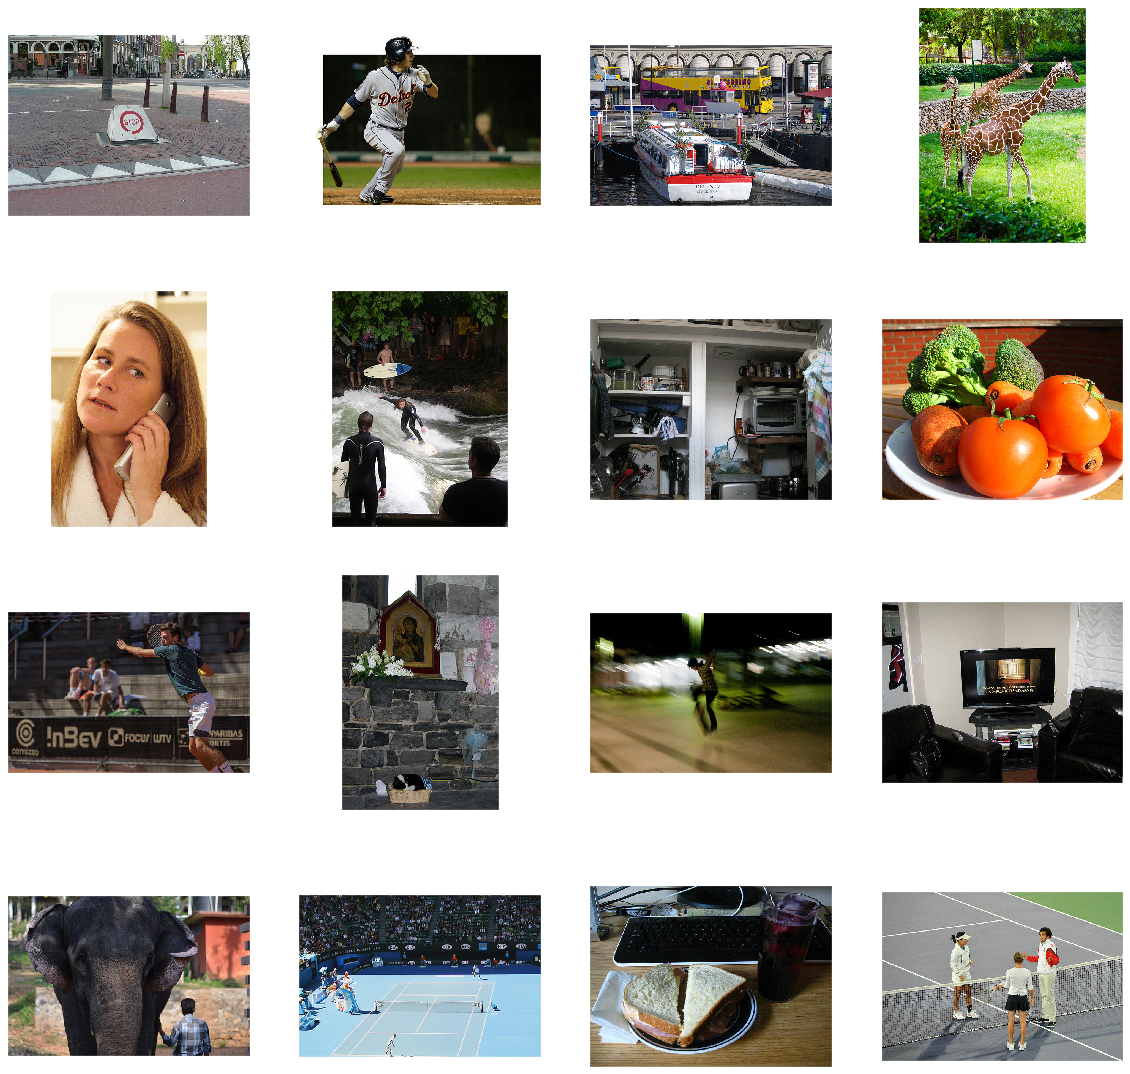

In [8]:
print('length of dataset:',len(coverit_dataset))

fig,axis = plt.subplots(4,4, figsize=(20,20))
axis = axis.reshape(-1)
for i,ax in enumerate(axis):
    sample = coverit_dataset[i]
    print(i, sample.shape)
    ax.imshow(sample)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

## Transformations

In [9]:
class PadCenterCrop(object):
    """
    Get the center/random crop of an image with given size. If image is too small pad it accordingly.
    """

    def __init__(self, out_size, is_random_crop=False):
        if isinstance(out_size, int):
            self.out_size = (out_size, out_size)
        elif isinstance(out_size, tuple):
            self.out_size = out_size
        else:
            raise Exception('Expect int or tuple only!')
        
        self.random_crop = is_random_crop

    def __call__(self, img):
                           
        w, h = img.size
        th, tw = self.out_size
        
        diff = min(img.size) - max(self.out_size)
        
        if diff < 0:
            img = ImageOps.expand(img, border=-diff, fill=0)
            w, h = img.size
            

        if w == tw and h == th:
            return img
        
        if self.random_crop:
            x1 = random.randint(0, w - tw)
            y1 = random.randint(0, h - th)
        else:
            x1 = (w - tw)/2 
            y1 = (h - th)/2 
        return img.crop((x1, y1, x1 + tw, y1 + th))

In [10]:
class ToTensor(object):
    """Converts a PIL.Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __init__(self,is_gray = False, do_normalize = True):
        self.is_gray = is_gray
        
        
    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic.transpose((2, 0, 1)))
            # backard compability
            return img.float().div(255)
        # handle PIL Image
        if pic.mode == 'I':
            img = torch.from_numpy(np.array(pic, np.int32, copy=False))
        elif pic.mode == 'I;16':
            img = torch.from_numpy(np.array(pic, np.int16, copy=False))
        else:
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
        # PIL image mode: 1, L, P, I, F, RGB, YCbCr, RGBA, CMYK
        if pic.mode == 'YCbCr':
            nchannel = 3
        elif pic.mode == 'I;16':
            nchannel = 1
        else:
            nchannel = len(pic.mode)
        img = img.view(pic.size[1], pic.size[0], nchannel)
        
        if self.is_gray:
            coef = torch.tensor([0.299,0.587,0.114])
            img = (img * coef.view(1,1,-1)).sum(axis=-1,keepdims=True)
        
        img = img.transpose(0, 1).transpose(0, 2).contiguous()
        if isinstance(img, torch.ByteTensor):
            return img.float().div(255)
        else:
            return img.div(255)

In [11]:
# toPIL = transforms.ToPILImage()
# # scale = Rescale((250,250))
# crop = PadCenterCrop((100,100))

In [12]:
# fig,axis = plt.subplots(4,4, figsize=(20,20))
# axis = axis.reshape(-1)
# for i,ax in enumerate(axis):
#     sample = crop(toPIL(coverit_dataset[i]))
#     print(i, sample.size)
#     ax.imshow(sample)
#     ax.grid(False)
#     ax.set_xticks([])
#     ax.set_yticks([])

In [13]:
# from inspect import getsource
# print(getsource(transforms.ToTensor))

## Transformed Dataset

In [14]:
coverit_dataset_transformed = CoverItDataset(root_dir=f'{PROJECT_DIR}/data/raw/coco-test2017',
                                             transform=transforms.Compose([
                                                 transforms.ToPILImage(),
                                                 PadCenterCrop(out_size=IMAGE_SIZE),
                                                 ToTensor(is_gray=True)
                                             ]))

In [15]:
print('length of dataset:',len(coverit_dataset_transformed))

length of dataset: 40670


In [16]:
def show_image(image, fig_size = None, log_dims=False, is_return=False):
    """
    Args:
        image: tensor
    """
    if len(image.shape) == 2:
        image = image[None,:,:]
        
    is_colored = not (image.shape[0] == 1)
    if is_colored:
        image_np = image.numpy().transpose(0,1,2)
    else:
        image_np = image.numpy()

    if log_dims:
        print(i, image_np.shape)

    if is_colored:
        plt.imshow(image_np)
    else:
        plt.imshow(image_np[0] ,cmap=plt.get_cmap('gray'))
    
    ax,fig = plt.gca(), plt.gcf()
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if fig_size:fig.set_size_inches(fig_size)
    
    if is_return:
        return fig

In [17]:
image = coverit_dataset_transformed[0]
image.shape

torch.Size([1, 256, 256])

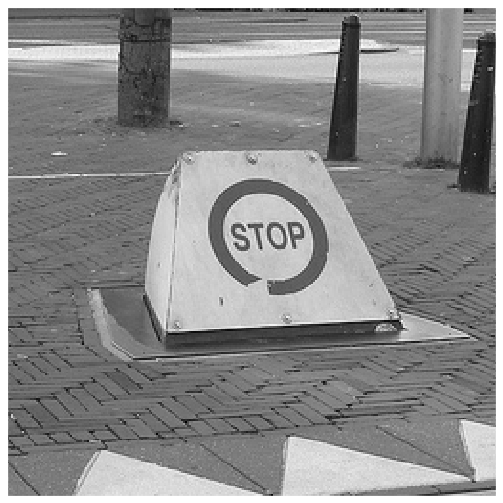

In [18]:
show_image(image, is_return=False)


## Data Loader

In [19]:
dataloader = DataLoader(coverit_dataset_transformed, batch_size = BATCH_SIZE, num_workers=2, shuffle=True)

In [20]:
batch = next(iter(dataloader))

In [21]:
batch.shape

torch.Size([16, 1, 256, 256])

In [92]:
def show_batch(batch, figsize = (20,20), log_dims=False):
    """
    Args:
        batch: tensor
    """
    subplot_size = int(batch.shape[0]**(1/2))
    is_colored = not (batch.shape[1] == 1)
    

    batch_np = batch.numpy().transpose(0,2,3,1)
   

    fig,axis = plt.subplots(subplot_size,subplot_size,figsize=figsize)
    axis = axis.reshape(-1)
    for i,ax in enumerate(axis):
        sample = batch_np[i]
        if log_dims:
            print(i, sample.shape)
            
        if is_colored:
            ax.imshow(sample)
        else:
            ax.imshow(sample.squeeze(),cmap=plt.get_cmap('gray'))

        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])

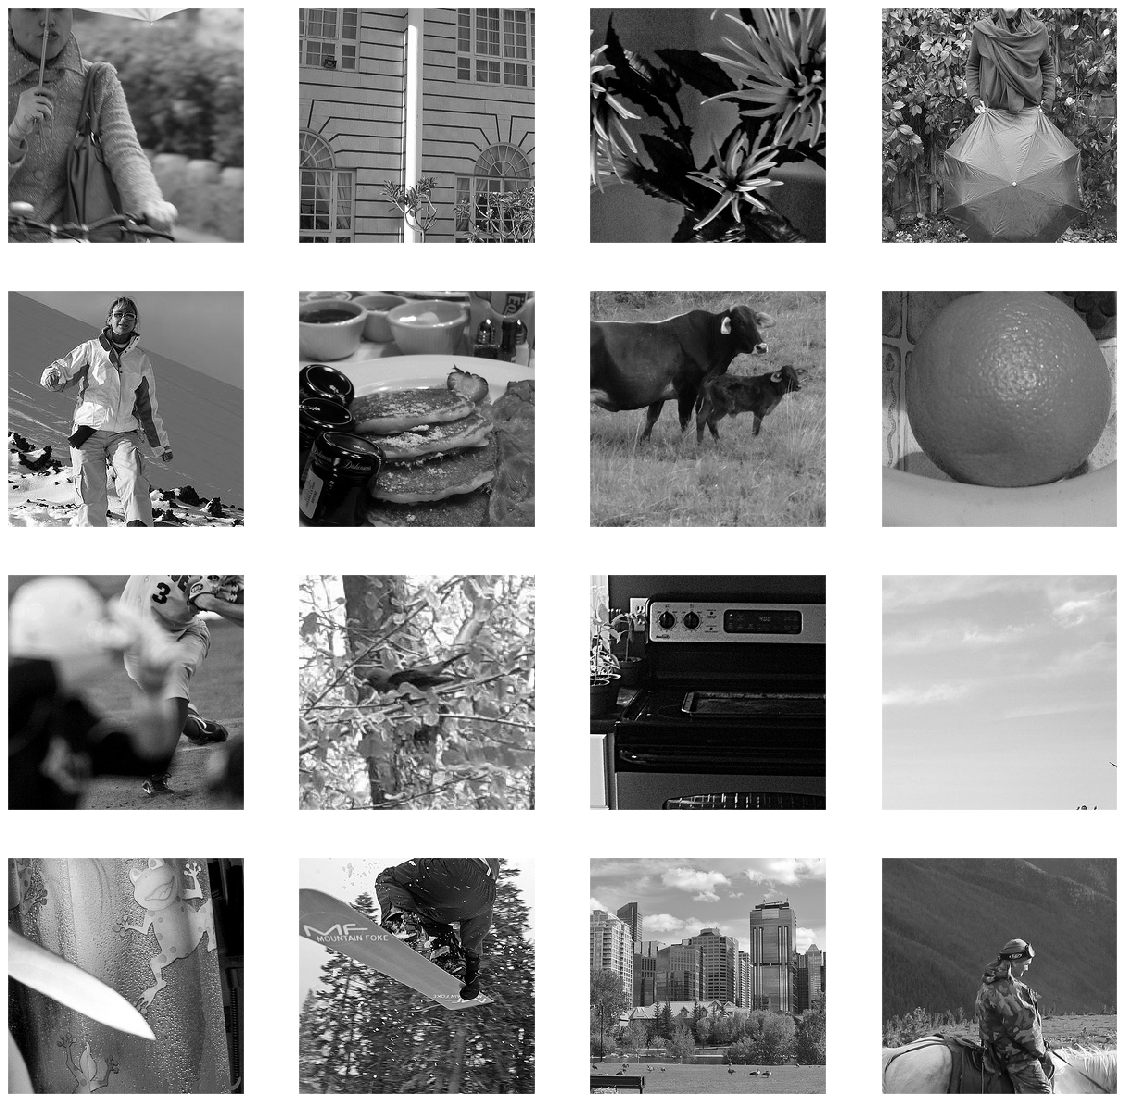

In [93]:
show_batch(batch)

# Model

In [25]:
def calc_cnn(
        input_size=128,
        padding=1,
        kernel_size=3,
        stride=1):
    output_size = (input_size+2*padding-kernel_size)//stride + 1
    return output_size

calc_cnn()

128

In [65]:
class Encoder(nn.Module):
    def __init__(self, nc=1, nhf=8, output_function=nn.Sigmoid):
        super(Encoder, self).__init__()
        # input is (3) x 256 x 256 if colored
        # input is (1) x 256 x 256 if not colored

        self.main = nn.Sequential( #16 1 256 256
            nn.Conv2d(nc, nhf, 3, 1, 1),#16 8 256 256
            nn.BatchNorm2d(nhf),
            nn.ReLU(True), #16 8 256 256
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2), #16 8 128 128
            nn.Conv2d(nhf, nhf*2, 3, 1, 1), #16 16 128 128
            nn.BatchNorm2d(nhf*2),
            nn.ReLU(True), 
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2), #16 16 64 64
            nn.Conv2d(nhf*2, nhf*4, 3, 1, 1),  #16 32 64 64
            nn.BatchNorm2d(nhf*4),
            nn.ReLU(True), 
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2), #16 32 32 32
            output_function()
        )

    def forward(self, input):
        output=self.main(input)
        return output

In [66]:
Encoder(nc=1)(batch).shape

torch.Size([16, 32, 32, 32])

**Look at transformerdecoder!!!**

In [67]:
class Decoder(nn.Module):
    def __init__(self, nc=1, nhf=8, output_function=nn.Sigmoid):
        super(Decoder, self).__init__()
        # input is (32) x 32 x 32 
        
        self.main = nn.Sequential( #16 32 32 32
            nn.UpsamplingBilinear2d(scale_factor=2), #16 32 64 64
            nn.ReLU(True),
            nn.BatchNorm2d(nhf*4),
            nn.Dropout2d(p=0.5),
            nn.Conv2d(nhf*4, nhf*2, 3, 1, 1), #16 16 64 64
            nn.UpsamplingBilinear2d(scale_factor=2), #16 16 128 128
            nn.ReLU(True),
            nn.BatchNorm2d(nhf*2),
            nn.Dropout2d(p=0.5),
            nn.Conv2d(nhf*2, nhf, 3, 1, 1), #16 8 128 128
            nn.UpsamplingBilinear2d(scale_factor=2), #16 8 256 256
            nn.ReLU(True),
            nn.BatchNorm2d(nhf),
            nn.Dropout2d(p=0.5),
            nn.Conv2d(nhf, nc, 3, 1, 1), #16 1 256 256
            output_function()
        )

    def forward(self, input):
        output=self.main(input)
        return output

In [68]:
Decoder(nc=1)(torch.rand((16,32,32,32))).shape

torch.Size([16, 1, 256, 256])

In [69]:
class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [70]:
encoder = Encoder().cuda()
decoder = Decoder().cuda()
autoencoder = AutoEncoder(encoder,decoder).cuda()

## Results Before Traning

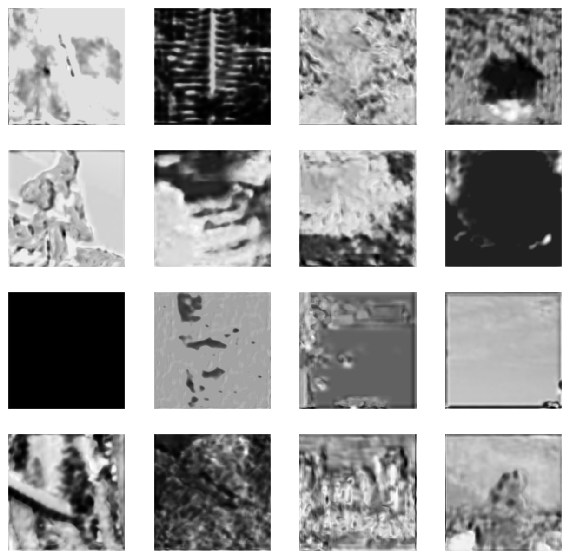

In [73]:
generated = autoencoder(batch.cuda()).detach().cpu()

show_batch(generated,figsize=(10,10))

In [304]:
# removing early experiments
# !rm -rf logs

In [74]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# Sets up a timestamped log directory.
logdir = "logs/train_data/" + datetime.now().strftime("%Y%m%d-%H%M")
print(logdir)
# Creates a file writer for the log directory.
writer = SummaryWriter(logdir)

logs/train_data/20200413-2332


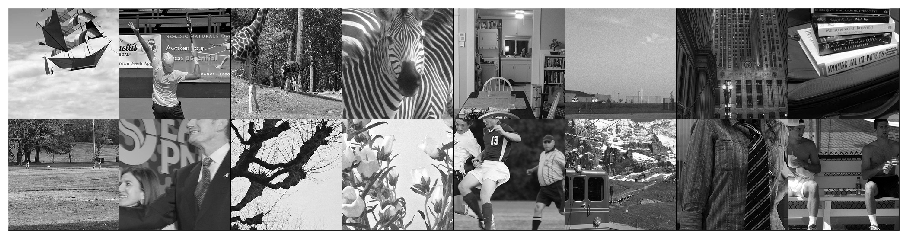

In [75]:
# get some random training images
# dataiter = iter(dataloader)
# images = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(batch)

# show images
show_image(img_grid.mean(dim=0, keepdim=True))

# write to tensorboard
writer.add_image('batch_cover_it_images', img_grid.mean(dim=0, keepdim=True), dataformats='CHW' )

In [76]:
writer.add_graph(autoencoder, images.cuda())
# writer.close()

In [77]:
# !tensorboard --logdir=runs/cover_it_experiment_1

## Load Model

In [78]:
model_id = logdir.split('/')[-1]
print(model_id)
model_directory = f"./models/{model_id}"
print(model_directory)

20200413-2332
./models/20200413-2332


In [79]:
#Create Dirs if doesn't exist

os.makedirs(f"./generated_images/{model_id}", exist_ok=True)
os.makedirs(f'./models/{model_id}/encoder',exist_ok=True)
os.makedirs(f'./models/{model_id}/decoder',exist_ok=True)

In [80]:
# load_specific = True


def load_model(encoder, decoder, model_dir, load_specific=None):
    
    start_epoch=0
    if load_specific:
        encoder.load_state_dict(torch.load(load_specific[0]))
        decoder.load_state_dict(torch.load(load_specific[1]))
        print('Loaded model parameters!')
    else:
        try:
            epoch = max([int(i.split('.')[0].split('_')[1]) for i in os.listdir(f'{model_dir}/encoder')])
            print(f"Found early model with parameters of epoch {epoch}")
            encoder_path = f"{model_dir}/encoder/encoder_{epoch}.pth"
            decoder_path = f"{model_dir}/decoder/decoder_{epoch}.pth"
            print("encoder_path:",encoder_path)
            
            encoder.load_state_dict(torch.load(encoder_path))
            decoder.load_state_dict(torch.load(decoder_path))
            print('Loaded model parameters!')
            
            start_epoch = int(start_epoch)+1
            
        except ValueError: # No saved models
            print("Could't find early model parameters!")
        
    print(f"Starting epoch: {start_epoch}")
    return start_epoch

In [81]:
for param in encoder.parameters():
    print(param[0])
    break

tensor([[[ 0.2830,  0.1937,  0.0940],
         [ 0.0932,  0.2325, -0.0924],
         [-0.0540, -0.1764, -0.0246]]], device='cuda:0',
       grad_fn=<SelectBackward>)


In [82]:
start_epoch = load_model(encoder, decoder, model_dir=model_directory,
                         load_specific=None)
start_epoch

Could't find early model parameters!
Starting epoch: 0


0

In [83]:
for param in encoder.parameters():
    print(param[0])
    break

tensor([[[ 0.2830,  0.1937,  0.0940],
         [ 0.0932,  0.2325, -0.0924],
         [-0.0540, -0.1764, -0.0246]]], device='cuda:0',
       grad_fn=<SelectBackward>)


# Training

In [84]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [85]:
running_loss = 0.0

for epoch in range(start_epoch, start_epoch+130):  # loop over the dataset multiple times

    for step, data in enumerate(dataloader, 0):

        # get the inputs
        inputs = data.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if step % 100 == 99:    # every 100 mini-batches...

            print("Epoch: {} | Step: {}  =========  Loss: {:.3}".format(
                epoch, step+1, loss.item()))

            # ...log the running loss
            writer.add_scalar('training loss',
                              running_loss / 100,
                              global_step=epoch * len(dataloader) + step)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            if step == 99:  # 1 image for each epoch
                generated = autoencoder(batch.cuda()).detach().cpu()

                # create grid of images
                img_grid = torchvision.utils.make_grid(generated)

                fig = show_image(img_grid.mean(dim=0, keepdim=True), is_return=True)

                # write to tensorboard
                writer.add_figure('batch_cover_it_images',
                                  fig,
                                  global_step=epoch * len(dataloader) + step)

#                 writer.add_figure('generated batch',
#                                 show_batch(generated*255),
#                                 global_step=epoch * len(dataloader) + step)

                torch.save(encoder.state_dict(),
                           f"./models/{model_id}/encoder/encoder_{epoch}.pth")
                torch.save(decoder.state_dict(),
                           f"./models/{model_id}/decoder/decoder{epoch}.pth")
                print('Saved model params to the disk!')

            running_loss = 0.0
print('Finished Training')

Epoch: 0 | Step: 100  =========  Loss: 0.0504
Saved model params to the disk!
Epoch: 0 | Step: 200  =========  Loss: 0.0432
Epoch: 0 | Step: 300  =========  Loss: 0.0381
Epoch: 0 | Step: 400  =========  Loss: 0.0427
Epoch: 0 | Step: 500  =========  Loss: 0.0372
Epoch: 0 | Step: 600  =========  Loss: 0.0381
Epoch: 0 | Step: 700  =========  Loss: 0.0508
Epoch: 0 | Step: 800  =========  Loss: 0.0375
Epoch: 0 | Step: 900  =========  Loss: 0.0313
Epoch: 0 | Step: 1000  =========  Loss: 0.0312
Epoch: 0 | Step: 1100  =========  Loss: 0.0284
Epoch: 0 | Step: 1200  =========  Loss: 0.0266
Epoch: 0 | Step: 1300  =========  Loss: 0.024
Epoch: 0 | Step: 1400  =========  Loss: 0.0375
Epoch: 0 | Step: 1500  =========  Loss: 0.0365
Epoch: 0 | Step: 1600  =========  Loss: 0.0365
Epoch: 0 | Step: 1700  =========  Loss: 0.0427
Epoch: 0 | Step: 1800  =========  Loss: 0.029
Epoch: 0 | Step: 1900  =========  Loss: 0.0332
Epoch: 0 | Step: 2000  =========  Loss: 0.0369
Epoch: 0 | Step: 2100  =========  Loss:

Epoch: 6 | Step: 2300  =========  Loss: 0.0274
Epoch: 6 | Step: 2400  =========  Loss: 0.0217
Epoch: 6 | Step: 2500  =========  Loss: 0.0441
Epoch: 7 | Step: 100  =========  Loss: 0.0252
Saved model params to the disk!
Epoch: 7 | Step: 200  =========  Loss: 0.0331
Epoch: 7 | Step: 300  =========  Loss: 0.0271
Epoch: 7 | Step: 400  =========  Loss: 0.0255
Epoch: 7 | Step: 500  =========  Loss: 0.0257
Epoch: 7 | Step: 600  =========  Loss: 0.0197
Epoch: 7 | Step: 700  =========  Loss: 0.0296
Epoch: 7 | Step: 800  =========  Loss: 0.0193
Epoch: 7 | Step: 900  =========  Loss: 0.0304
Epoch: 7 | Step: 1000  =========  Loss: 0.0254
Epoch: 7 | Step: 1100  =========  Loss: 0.0268
Epoch: 7 | Step: 1200  =========  Loss: 0.0265
Epoch: 7 | Step: 1300  =========  Loss: 0.0325
Epoch: 7 | Step: 1400  =========  Loss: 0.0278
Epoch: 7 | Step: 1500  =========  Loss: 0.0251
Epoch: 7 | Step: 1600  =========  Loss: 0.0256
Epoch: 7 | Step: 1700  =========  Loss: 0.0217
Epoch: 7 | Step: 1800  =========  Los

Epoch: 13 | Step: 1800  =========  Loss: 0.0258
Epoch: 13 | Step: 1900  =========  Loss: 0.027
Epoch: 13 | Step: 2000  =========  Loss: 0.0229
Epoch: 13 | Step: 2100  =========  Loss: 0.0347
Epoch: 13 | Step: 2200  =========  Loss: 0.0263
Epoch: 13 | Step: 2300  =========  Loss: 0.0305
Epoch: 13 | Step: 2400  =========  Loss: 0.0319
Epoch: 13 | Step: 2500  =========  Loss: 0.0283
Epoch: 14 | Step: 100  =========  Loss: 0.0251
Saved model params to the disk!
Epoch: 14 | Step: 200  =========  Loss: 0.0342
Epoch: 14 | Step: 300  =========  Loss: 0.0233
Epoch: 14 | Step: 400  =========  Loss: 0.0307
Epoch: 14 | Step: 500  =========  Loss: 0.0254
Epoch: 14 | Step: 600  =========  Loss: 0.0315
Epoch: 14 | Step: 700  =========  Loss: 0.0247
Epoch: 14 | Step: 800  =========  Loss: 0.0221
Epoch: 14 | Step: 900  =========  Loss: 0.0388
Epoch: 14 | Step: 1000  =========  Loss: 0.0314
Epoch: 14 | Step: 1100  =========  Loss: 0.025
Epoch: 14 | Step: 1200  =========  Loss: 0.025
Epoch: 14 | Step: 13

Epoch: 20 | Step: 1100  =========  Loss: 0.0218
Epoch: 20 | Step: 1200  =========  Loss: 0.0303
Epoch: 20 | Step: 1300  =========  Loss: 0.0403
Epoch: 20 | Step: 1400  =========  Loss: 0.0204
Epoch: 20 | Step: 1500  =========  Loss: 0.0259
Epoch: 20 | Step: 1600  =========  Loss: 0.028
Epoch: 20 | Step: 1700  =========  Loss: 0.033
Epoch: 20 | Step: 1800  =========  Loss: 0.0231
Epoch: 20 | Step: 1900  =========  Loss: 0.0305
Epoch: 20 | Step: 2000  =========  Loss: 0.0265
Epoch: 20 | Step: 2100  =========  Loss: 0.0288
Epoch: 20 | Step: 2200  =========  Loss: 0.0326
Epoch: 20 | Step: 2300  =========  Loss: 0.0413
Epoch: 20 | Step: 2400  =========  Loss: 0.021
Epoch: 20 | Step: 2500  =========  Loss: 0.0365
Epoch: 21 | Step: 100  =========  Loss: 0.0305
Saved model params to the disk!
Epoch: 21 | Step: 200  =========  Loss: 0.0361
Epoch: 21 | Step: 300  =========  Loss: 0.0293
Epoch: 21 | Step: 400  =========  Loss: 0.0194
Epoch: 21 | Step: 500  =========  Loss: 0.0271
Epoch: 21 | Step

Epoch: 27 | Step: 400  =========  Loss: 0.0289
Epoch: 27 | Step: 500  =========  Loss: 0.0303
Epoch: 27 | Step: 600  =========  Loss: 0.0323
Epoch: 27 | Step: 700  =========  Loss: 0.0235
Epoch: 27 | Step: 800  =========  Loss: 0.0303
Epoch: 27 | Step: 900  =========  Loss: 0.0234
Epoch: 27 | Step: 1000  =========  Loss: 0.0234
Epoch: 27 | Step: 1100  =========  Loss: 0.0254
Epoch: 27 | Step: 1200  =========  Loss: 0.0314
Epoch: 27 | Step: 1300  =========  Loss: 0.0324
Epoch: 27 | Step: 1400  =========  Loss: 0.0349
Epoch: 27 | Step: 1500  =========  Loss: 0.0334
Epoch: 27 | Step: 1600  =========  Loss: 0.0219
Epoch: 27 | Step: 1700  =========  Loss: 0.0455
Epoch: 27 | Step: 1800  =========  Loss: 0.021
Epoch: 27 | Step: 1900  =========  Loss: 0.0174
Epoch: 27 | Step: 2000  =========  Loss: 0.0279
Epoch: 27 | Step: 2100  =========  Loss: 0.0199
Epoch: 27 | Step: 2200  =========  Loss: 0.0252
Epoch: 27 | Step: 2300  =========  Loss: 0.0265
Epoch: 27 | Step: 2400  =========  Loss: 0.0249

Epoch: 33 | Step: 2300  =========  Loss: 0.0327
Epoch: 33 | Step: 2400  =========  Loss: 0.0283
Epoch: 33 | Step: 2500  =========  Loss: 0.027
Epoch: 34 | Step: 100  =========  Loss: 0.0412
Saved model params to the disk!
Epoch: 34 | Step: 200  =========  Loss: 0.0275
Epoch: 34 | Step: 300  =========  Loss: 0.029
Epoch: 34 | Step: 400  =========  Loss: 0.0251
Epoch: 34 | Step: 500  =========  Loss: 0.0313
Epoch: 34 | Step: 600  =========  Loss: 0.0315
Epoch: 34 | Step: 700  =========  Loss: 0.0302
Epoch: 34 | Step: 800  =========  Loss: 0.0228
Epoch: 34 | Step: 900  =========  Loss: 0.0388
Epoch: 34 | Step: 1000  =========  Loss: 0.0328
Epoch: 34 | Step: 1100  =========  Loss: 0.0236
Epoch: 34 | Step: 1200  =========  Loss: 0.0243
Epoch: 34 | Step: 1300  =========  Loss: 0.0277
Epoch: 34 | Step: 1400  =========  Loss: 0.0335
Epoch: 34 | Step: 1500  =========  Loss: 0.0273
Epoch: 34 | Step: 1600  =========  Loss: 0.0313
Epoch: 34 | Step: 1700  =========  Loss: 0.031
Epoch: 34 | Step: 18

Epoch: 40 | Step: 1600  =========  Loss: 0.0264
Epoch: 40 | Step: 1700  =========  Loss: 0.044
Epoch: 40 | Step: 1800  =========  Loss: 0.0327
Epoch: 40 | Step: 1900  =========  Loss: 0.033
Epoch: 40 | Step: 2000  =========  Loss: 0.0274
Epoch: 40 | Step: 2100  =========  Loss: 0.0313
Epoch: 40 | Step: 2200  =========  Loss: 0.0263
Epoch: 40 | Step: 2300  =========  Loss: 0.0284
Epoch: 40 | Step: 2400  =========  Loss: 0.0257
Epoch: 40 | Step: 2500  =========  Loss: 0.0196
Epoch: 41 | Step: 100  =========  Loss: 0.0246
Saved model params to the disk!
Epoch: 41 | Step: 200  =========  Loss: 0.0314
Epoch: 41 | Step: 300  =========  Loss: 0.022
Epoch: 41 | Step: 400  =========  Loss: 0.0247
Epoch: 41 | Step: 500  =========  Loss: 0.0326
Epoch: 41 | Step: 600  =========  Loss: 0.0349
Epoch: 41 | Step: 700  =========  Loss: 0.0297
Epoch: 41 | Step: 800  =========  Loss: 0.0268
Epoch: 41 | Step: 900  =========  Loss: 0.0278
Epoch: 41 | Step: 1000  =========  Loss: 0.0195
Epoch: 41 | Step: 11

Epoch: 47 | Step: 900  =========  Loss: 0.0214
Epoch: 47 | Step: 1000  =========  Loss: 0.0274
Epoch: 47 | Step: 1100  =========  Loss: 0.0237
Epoch: 47 | Step: 1200  =========  Loss: 0.0363
Epoch: 47 | Step: 1300  =========  Loss: 0.0208
Epoch: 47 | Step: 1400  =========  Loss: 0.0292
Epoch: 47 | Step: 1500  =========  Loss: 0.0307
Epoch: 47 | Step: 1600  =========  Loss: 0.0372
Epoch: 47 | Step: 1700  =========  Loss: 0.0225
Epoch: 47 | Step: 1800  =========  Loss: 0.0289
Epoch: 47 | Step: 1900  =========  Loss: 0.0272
Epoch: 47 | Step: 2000  =========  Loss: 0.0315
Epoch: 47 | Step: 2100  =========  Loss: 0.03
Epoch: 47 | Step: 2200  =========  Loss: 0.0296
Epoch: 47 | Step: 2300  =========  Loss: 0.022
Epoch: 47 | Step: 2400  =========  Loss: 0.0302
Epoch: 47 | Step: 2500  =========  Loss: 0.0265
Epoch: 48 | Step: 100  =========  Loss: 0.0251
Saved model params to the disk!
Epoch: 48 | Step: 200  =========  Loss: 0.0287
Epoch: 48 | Step: 300  =========  Loss: 0.0298
Epoch: 48 | Ste

Epoch: 54 | Step: 200  =========  Loss: 0.0241
Epoch: 54 | Step: 300  =========  Loss: 0.023
Epoch: 54 | Step: 400  =========  Loss: 0.0271
Epoch: 54 | Step: 500  =========  Loss: 0.0283
Epoch: 54 | Step: 600  =========  Loss: 0.025
Epoch: 54 | Step: 700  =========  Loss: 0.0318
Epoch: 54 | Step: 800  =========  Loss: 0.0369
Epoch: 54 | Step: 900  =========  Loss: 0.0234
Epoch: 54 | Step: 1000  =========  Loss: 0.0239
Epoch: 54 | Step: 1100  =========  Loss: 0.0328
Epoch: 54 | Step: 1200  =========  Loss: 0.0297
Epoch: 54 | Step: 1300  =========  Loss: 0.0226
Epoch: 54 | Step: 1400  =========  Loss: 0.0314
Epoch: 54 | Step: 1500  =========  Loss: 0.0233
Epoch: 54 | Step: 1600  =========  Loss: 0.0239
Epoch: 54 | Step: 1700  =========  Loss: 0.0243
Epoch: 54 | Step: 1800  =========  Loss: 0.0244
Epoch: 54 | Step: 1900  =========  Loss: 0.0244
Epoch: 54 | Step: 2000  =========  Loss: 0.0277
Epoch: 54 | Step: 2100  =========  Loss: 0.0278
Epoch: 54 | Step: 2200  =========  Loss: 0.0371
Ep

Epoch: 60 | Step: 2100  =========  Loss: 0.0315
Epoch: 60 | Step: 2200  =========  Loss: 0.0319
Epoch: 60 | Step: 2300  =========  Loss: 0.0258
Epoch: 60 | Step: 2400  =========  Loss: 0.0273
Epoch: 60 | Step: 2500  =========  Loss: 0.0299
Epoch: 61 | Step: 100  =========  Loss: 0.024
Saved model params to the disk!
Epoch: 61 | Step: 200  =========  Loss: 0.0228
Epoch: 61 | Step: 300  =========  Loss: 0.0281
Epoch: 61 | Step: 400  =========  Loss: 0.0284
Epoch: 61 | Step: 500  =========  Loss: 0.0232
Epoch: 61 | Step: 600  =========  Loss: 0.0255
Epoch: 61 | Step: 700  =========  Loss: 0.0323
Epoch: 61 | Step: 800  =========  Loss: 0.0186
Epoch: 61 | Step: 900  =========  Loss: 0.0268
Epoch: 61 | Step: 1000  =========  Loss: 0.0354
Epoch: 61 | Step: 1100  =========  Loss: 0.0239
Epoch: 61 | Step: 1200  =========  Loss: 0.0255
Epoch: 61 | Step: 1300  =========  Loss: 0.026
Epoch: 61 | Step: 1400  =========  Loss: 0.0409
Epoch: 61 | Step: 1500  =========  Loss: 0.0286
Epoch: 61 | Step: 1

Epoch: 67 | Step: 1400  =========  Loss: 0.0236
Epoch: 67 | Step: 1500  =========  Loss: 0.0212
Epoch: 67 | Step: 1600  =========  Loss: 0.0196
Epoch: 67 | Step: 1700  =========  Loss: 0.0289
Epoch: 67 | Step: 1800  =========  Loss: 0.0232
Epoch: 67 | Step: 1900  =========  Loss: 0.0322
Epoch: 67 | Step: 2000  =========  Loss: 0.0291
Epoch: 67 | Step: 2100  =========  Loss: 0.0263
Epoch: 67 | Step: 2200  =========  Loss: 0.0282
Epoch: 67 | Step: 2300  =========  Loss: 0.0268
Epoch: 67 | Step: 2400  =========  Loss: 0.024
Epoch: 67 | Step: 2500  =========  Loss: 0.0265
Epoch: 68 | Step: 100  =========  Loss: 0.0303
Saved model params to the disk!
Epoch: 68 | Step: 200  =========  Loss: 0.0311
Epoch: 68 | Step: 300  =========  Loss: 0.026
Epoch: 68 | Step: 400  =========  Loss: 0.0333
Epoch: 68 | Step: 500  =========  Loss: 0.0237
Epoch: 68 | Step: 600  =========  Loss: 0.0311
Epoch: 68 | Step: 700  =========  Loss: 0.0237
Epoch: 68 | Step: 800  =========  Loss: 0.0319
Epoch: 68 | Step: 

Epoch: 74 | Step: 700  =========  Loss: 0.0327
Epoch: 74 | Step: 800  =========  Loss: 0.0293
Epoch: 74 | Step: 900  =========  Loss: 0.0221
Epoch: 74 | Step: 1000  =========  Loss: 0.0259
Epoch: 74 | Step: 1100  =========  Loss: 0.0242
Epoch: 74 | Step: 1200  =========  Loss: 0.0307
Epoch: 74 | Step: 1300  =========  Loss: 0.0375
Epoch: 74 | Step: 1400  =========  Loss: 0.0281
Epoch: 74 | Step: 1500  =========  Loss: 0.0221
Epoch: 74 | Step: 1600  =========  Loss: 0.0292
Epoch: 74 | Step: 1700  =========  Loss: 0.0265
Epoch: 74 | Step: 1800  =========  Loss: 0.0269
Epoch: 74 | Step: 1900  =========  Loss: 0.033
Epoch: 74 | Step: 2000  =========  Loss: 0.0248
Epoch: 74 | Step: 2100  =========  Loss: 0.0306
Epoch: 74 | Step: 2200  =========  Loss: 0.0207
Epoch: 74 | Step: 2300  =========  Loss: 0.024
Epoch: 74 | Step: 2400  =========  Loss: 0.0223
Epoch: 74 | Step: 2500  =========  Loss: 0.0215
Epoch: 75 | Step: 100  =========  Loss: 0.0256
Saved model params to the disk!
Epoch: 75 | St

Epoch: 81 | Step: 100  =========  Loss: 0.0294
Saved model params to the disk!
Epoch: 81 | Step: 200  =========  Loss: 0.0299
Epoch: 81 | Step: 300  =========  Loss: 0.0345
Epoch: 81 | Step: 400  =========  Loss: 0.0296
Epoch: 81 | Step: 500  =========  Loss: 0.0234
Epoch: 81 | Step: 600  =========  Loss: 0.0284
Epoch: 81 | Step: 700  =========  Loss: 0.0369
Epoch: 81 | Step: 800  =========  Loss: 0.0319
Epoch: 81 | Step: 900  =========  Loss: 0.0317
Epoch: 81 | Step: 1000  =========  Loss: 0.0276
Epoch: 81 | Step: 1100  =========  Loss: 0.0259
Epoch: 81 | Step: 1200  =========  Loss: 0.0272
Epoch: 81 | Step: 1300  =========  Loss: 0.0316
Epoch: 81 | Step: 1400  =========  Loss: 0.0256
Epoch: 81 | Step: 1500  =========  Loss: 0.0241
Epoch: 81 | Step: 1600  =========  Loss: 0.026
Epoch: 81 | Step: 1700  =========  Loss: 0.0264
Epoch: 81 | Step: 1800  =========  Loss: 0.0272
Epoch: 81 | Step: 1900  =========  Loss: 0.0306
Epoch: 81 | Step: 2000  =========  Loss: 0.0351
Epoch: 81 | Step: 

Epoch: 87 | Step: 1900  =========  Loss: 0.0408
Epoch: 87 | Step: 2000  =========  Loss: 0.028
Epoch: 87 | Step: 2100  =========  Loss: 0.0219
Epoch: 87 | Step: 2200  =========  Loss: 0.0253
Epoch: 87 | Step: 2300  =========  Loss: 0.0266
Epoch: 87 | Step: 2400  =========  Loss: 0.029
Epoch: 87 | Step: 2500  =========  Loss: 0.0305
Epoch: 88 | Step: 100  =========  Loss: 0.0344
Saved model params to the disk!
Epoch: 88 | Step: 200  =========  Loss: 0.0322
Epoch: 88 | Step: 300  =========  Loss: 0.0368
Epoch: 88 | Step: 400  =========  Loss: 0.03
Epoch: 88 | Step: 500  =========  Loss: 0.0276
Epoch: 88 | Step: 600  =========  Loss: 0.0297
Epoch: 88 | Step: 700  =========  Loss: 0.0292
Epoch: 88 | Step: 800  =========  Loss: 0.0247
Epoch: 88 | Step: 900  =========  Loss: 0.0296
Epoch: 88 | Step: 1000  =========  Loss: 0.0302
Epoch: 88 | Step: 1100  =========  Loss: 0.027
Epoch: 88 | Step: 1200  =========  Loss: 0.0238
Epoch: 88 | Step: 1300  =========  Loss: 0.0219
Epoch: 88 | Step: 1400

Epoch: 94 | Step: 1200  =========  Loss: 0.0217
Epoch: 94 | Step: 1300  =========  Loss: 0.0248
Epoch: 94 | Step: 1400  =========  Loss: 0.0323
Epoch: 94 | Step: 1500  =========  Loss: 0.0232
Epoch: 94 | Step: 1600  =========  Loss: 0.0218
Epoch: 94 | Step: 1700  =========  Loss: 0.033
Epoch: 94 | Step: 1800  =========  Loss: 0.0342
Epoch: 94 | Step: 1900  =========  Loss: 0.0212
Epoch: 94 | Step: 2000  =========  Loss: 0.0241
Epoch: 94 | Step: 2100  =========  Loss: 0.0269
Epoch: 94 | Step: 2200  =========  Loss: 0.0176
Epoch: 94 | Step: 2300  =========  Loss: 0.0342
Epoch: 94 | Step: 2400  =========  Loss: 0.0337
Epoch: 94 | Step: 2500  =========  Loss: 0.0214
Epoch: 95 | Step: 100  =========  Loss: 0.03
Saved model params to the disk!
Epoch: 95 | Step: 200  =========  Loss: 0.0303
Epoch: 95 | Step: 300  =========  Loss: 0.0258
Epoch: 95 | Step: 400  =========  Loss: 0.0358
Epoch: 95 | Step: 500  =========  Loss: 0.0236
Epoch: 95 | Step: 600  =========  Loss: 0.0294
Epoch: 95 | Step:

Epoch: 101 | Step: 400  =========  Loss: 0.0206
Epoch: 101 | Step: 500  =========  Loss: 0.029
Epoch: 101 | Step: 600  =========  Loss: 0.0225
Epoch: 101 | Step: 700  =========  Loss: 0.0227
Epoch: 101 | Step: 800  =========  Loss: 0.0353
Epoch: 101 | Step: 900  =========  Loss: 0.026
Epoch: 101 | Step: 1000  =========  Loss: 0.0266
Epoch: 101 | Step: 1100  =========  Loss: 0.0254
Epoch: 101 | Step: 1200  =========  Loss: 0.0322
Epoch: 101 | Step: 1300  =========  Loss: 0.0239
Epoch: 101 | Step: 1400  =========  Loss: 0.0232
Epoch: 101 | Step: 1500  =========  Loss: 0.0265
Epoch: 101 | Step: 1600  =========  Loss: 0.0219
Epoch: 101 | Step: 1700  =========  Loss: 0.0272
Epoch: 101 | Step: 1800  =========  Loss: 0.029
Epoch: 101 | Step: 1900  =========  Loss: 0.0253
Epoch: 101 | Step: 2000  =========  Loss: 0.02
Epoch: 101 | Step: 2100  =========  Loss: 0.042
Epoch: 101 | Step: 2200  =========  Loss: 0.0253
Epoch: 101 | Step: 2300  =========  Loss: 0.0266
Epoch: 101 | Step: 2400  =======

Epoch: 107 | Step: 1900  =========  Loss: 0.0289
Epoch: 107 | Step: 2000  =========  Loss: 0.0202
Epoch: 107 | Step: 2100  =========  Loss: 0.0234
Epoch: 107 | Step: 2200  =========  Loss: 0.0218
Epoch: 107 | Step: 2300  =========  Loss: 0.0243
Epoch: 107 | Step: 2400  =========  Loss: 0.0276
Epoch: 107 | Step: 2500  =========  Loss: 0.0278
Epoch: 108 | Step: 100  =========  Loss: 0.0224
Saved model params to the disk!
Epoch: 108 | Step: 200  =========  Loss: 0.0337
Epoch: 108 | Step: 300  =========  Loss: 0.0262
Epoch: 108 | Step: 400  =========  Loss: 0.0294
Epoch: 108 | Step: 500  =========  Loss: 0.0304
Epoch: 108 | Step: 600  =========  Loss: 0.0323
Epoch: 108 | Step: 700  =========  Loss: 0.0235
Epoch: 108 | Step: 800  =========  Loss: 0.0286
Epoch: 108 | Step: 900  =========  Loss: 0.0242
Epoch: 108 | Step: 1000  =========  Loss: 0.0261
Epoch: 108 | Step: 1100  =========  Loss: 0.0262
Epoch: 108 | Step: 1200  =========  Loss: 0.0303
Epoch: 108 | Step: 1300  =========  Loss: 0.03

Epoch: 114 | Step: 900  =========  Loss: 0.0307
Epoch: 114 | Step: 1000  =========  Loss: 0.0248
Epoch: 114 | Step: 1100  =========  Loss: 0.0191
Epoch: 114 | Step: 1200  =========  Loss: 0.0227
Epoch: 114 | Step: 1300  =========  Loss: 0.0309
Epoch: 114 | Step: 1400  =========  Loss: 0.0256
Epoch: 114 | Step: 1500  =========  Loss: 0.0247
Epoch: 114 | Step: 1600  =========  Loss: 0.0366
Epoch: 114 | Step: 1700  =========  Loss: 0.0277
Epoch: 114 | Step: 1800  =========  Loss: 0.0254
Epoch: 114 | Step: 1900  =========  Loss: 0.0298
Epoch: 114 | Step: 2000  =========  Loss: 0.0239
Epoch: 114 | Step: 2100  =========  Loss: 0.0215
Epoch: 114 | Step: 2200  =========  Loss: 0.0295
Epoch: 114 | Step: 2300  =========  Loss: 0.0227
Epoch: 114 | Step: 2400  =========  Loss: 0.0233
Epoch: 114 | Step: 2500  =========  Loss: 0.0218
Epoch: 115 | Step: 100  =========  Loss: 0.0254
Saved model params to the disk!
Epoch: 115 | Step: 200  =========  Loss: 0.0258
Epoch: 115 | Step: 300  =========  Loss:

Epoch: 120 | Step: 2400  =========  Loss: 0.0257
Epoch: 120 | Step: 2500  =========  Loss: 0.0243
Epoch: 121 | Step: 100  =========  Loss: 0.0215
Saved model params to the disk!
Epoch: 121 | Step: 200  =========  Loss: 0.0279
Epoch: 121 | Step: 300  =========  Loss: 0.0239
Epoch: 121 | Step: 400  =========  Loss: 0.0273
Epoch: 121 | Step: 500  =========  Loss: 0.0281
Epoch: 121 | Step: 600  =========  Loss: 0.029
Epoch: 121 | Step: 700  =========  Loss: 0.0216
Epoch: 121 | Step: 800  =========  Loss: 0.033
Epoch: 121 | Step: 900  =========  Loss: 0.025
Epoch: 121 | Step: 1000  =========  Loss: 0.0202
Epoch: 121 | Step: 1100  =========  Loss: 0.029
Epoch: 121 | Step: 1200  =========  Loss: 0.0211
Epoch: 121 | Step: 1300  =========  Loss: 0.0254
Epoch: 121 | Step: 1400  =========  Loss: 0.025
Epoch: 121 | Step: 1500  =========  Loss: 0.0299
Epoch: 121 | Step: 1600  =========  Loss: 0.0255
Epoch: 121 | Step: 1700  =========  Loss: 0.0257
Epoch: 121 | Step: 1800  =========  Loss: 0.037
Epo

Epoch: 127 | Step: 1400  =========  Loss: 0.0378
Epoch: 127 | Step: 1500  =========  Loss: 0.0379
Epoch: 127 | Step: 1600  =========  Loss: 0.0276
Epoch: 127 | Step: 1700  =========  Loss: 0.0179
Epoch: 127 | Step: 1800  =========  Loss: 0.0323
Epoch: 127 | Step: 1900  =========  Loss: 0.019
Epoch: 127 | Step: 2000  =========  Loss: 0.0251
Epoch: 127 | Step: 2100  =========  Loss: 0.019
Epoch: 127 | Step: 2200  =========  Loss: 0.0245
Epoch: 127 | Step: 2300  =========  Loss: 0.0272
Epoch: 127 | Step: 2400  =========  Loss: 0.0237
Epoch: 127 | Step: 2500  =========  Loss: 0.0398
Epoch: 128 | Step: 100  =========  Loss: 0.0326
Saved model params to the disk!
Epoch: 128 | Step: 200  =========  Loss: 0.0248
Epoch: 128 | Step: 300  =========  Loss: 0.0195
Epoch: 128 | Step: 400  =========  Loss: 0.0287
Epoch: 128 | Step: 500  =========  Loss: 0.0232
Epoch: 128 | Step: 600  =========  Loss: 0.0223
Epoch: 128 | Step: 700  =========  Loss: 0.0346
Epoch: 128 | Step: 800  =========  Loss: 0.030

In [326]:
# torch.save(encoder.state_dict(),
#            f"./models/{model_id}/encoder/encoder_{epoch}.pth")
# torch.save(decoder.state_dict(),
#            f"./models/{model_id}/decoder/decoder{epoch}.pth")

## Results After Traning

### Autoencoder Output

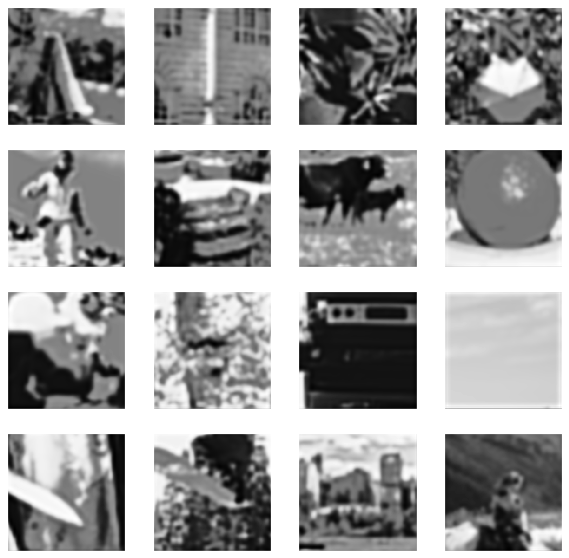

In [182]:
# generated = autoencoder(batch.cuda()).detach().cpu() #single sample from pred dist

generated = [autoencoder(batch.cuda()).detach().cpu() for i in range(50)] # mean over 50 samples
generated = torch.cat(generated,dim=1).mean(dim=1, keepdim=True)

show_batch(generated, figsize=(10,10))

### Decoded from random

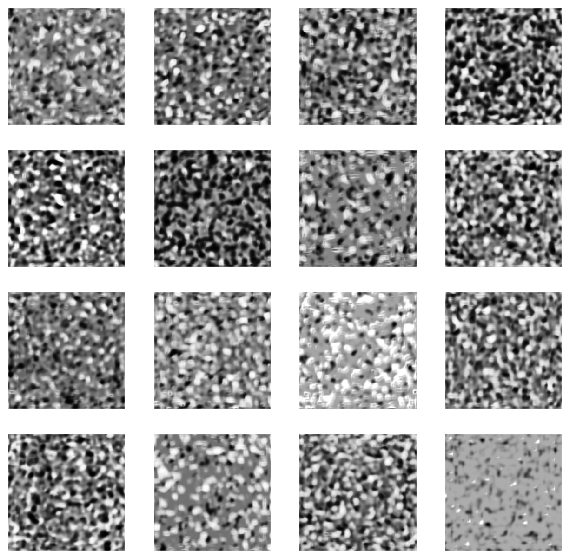

In [183]:
encoded_from_random = decoder(torch.randn((16,32,32,32)).cuda()).detach().cpu()

show_batch(encoded_from_random, figsize=(10,10))

### Shift encoded + decode

In [503]:
# diag_vec = torch.cat([torch.ones(16)*-1, torch.ones(16)])

# torch.diag(diag_vec)@torch.diag(torch.randn(32))

# # torch.tril(torch.ones(32,32))

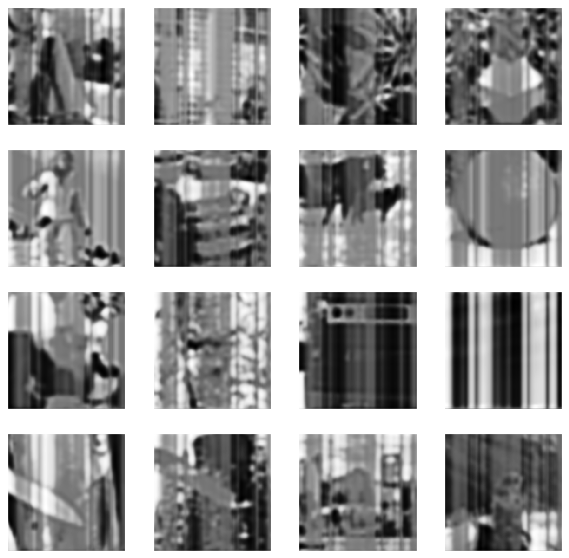

In [185]:
random_diag =  torch.diag(torch.diag(torch.randn(32)/30))
# encoded = encoder(batch.cuda()).detach().cpu()
# encoded = encoded.add_(torch.diag(torch.diag(torch.randn(32)/30)))
# encoded = encoded.mul(1/encoded.max())

# decoded = decoder(encoded.cuda()).detach().cpu()

decoded = []
for i in range(25):
    encoded = encoder(batch.cuda()).detach().cpu()
    encoded = encoded.add_(random_diag)
    encoded = encoded.mul(1/encoded.max())

    decoded.append(decoder(encoded.cuda()).detach().cpu())
decoded = torch.cat(decoded,dim=1).mean(dim=1, keepdim=True)

show_batch(decoded, figsize=(10,10))

### Noise + encoded -> decode

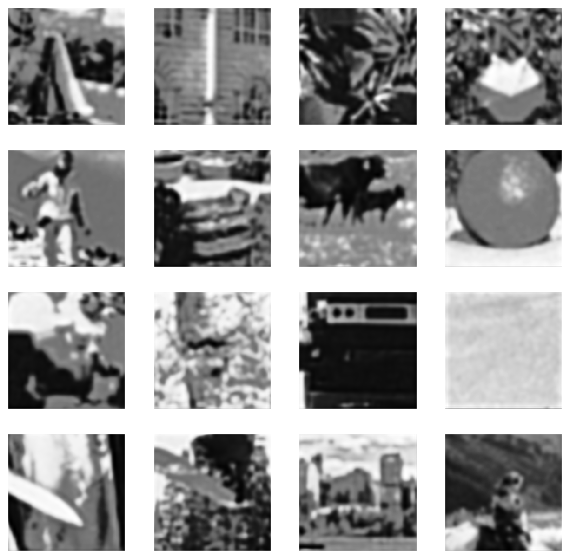

In [173]:
noise = torch.randn_like(encoded)/500
# encoded = encoder(batch.cuda()).detach().cpu()
# encoded = encoded.add_(torch.randn_like(encoded)/500)
# encoded = encoded.mul(1/encoded.max())

# decoded = decoder(encoded.cuda()).detach().cpu()

decoded = []

for i in range(25):
    encoded = encoder(batch.cuda()).detach().cpu()
    encoded = encoded.add_(noise)
    encoded = encoded.mul(1/encoded.max())

    decoded.append(decoder(encoded.cuda()).detach().cpu())
    
decoded = torch.cat(decoded,dim=1).mean(dim=1, keepdim=True)

show_batch(decoded, figsize=(10,10))